# Test SPAMS.fistaGraph

Docs http://spams-devel.gforge.inria.fr/doc-R/html/doc_spams006.html#sec39

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import networkx as nx
import scipy
import scipy.sparse as ssp

import time
import spams

def flatten(list_of_lists): return [item for sublist in list_of_lists for item in sublist]


## I. Generate synthetic "easy" graph and graph signals

In [2]:
num_nodes = 15
p_edge = 0.3
g1 = nx.fast_gnp_random_graph(num_nodes, p_edge)
g2 = nx.fast_gnp_random_graph(num_nodes, p_edge)

nx.relabel_nodes(g2, {number: number + 15 for number in g2.nodes}, copy=False)

g = nx.compose(g1, g2)

g.add_edge(1, 25)
g.add_edge(2, 20)
g.add_edge(3, 15)

/Users/alex/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


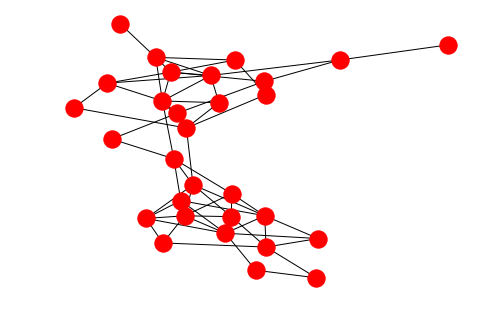

In [3]:
nx.draw_spring(g)

In [4]:
edgelist = nx.to_pandas_edgelist(g).values

#### True signal comes from 0 and its neighbors

In [5]:
signal_nodes = [0]+[n for n in g.neighbors(0)]
signal_nodes

[0, 3, 5, 6, 9, 13, 14]

#### First half is class 1, second half is class 0

In [6]:
NUM_POSITIVES = 20
NUM_NEGATIVES = 20
y = np.concatenate((np.ones(NUM_POSITIVES), np.zeros(NUM_NEGATIVES)))
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [7]:
data = pd.DataFrame(np.random.normal(size=(NUM_POSITIVES+NUM_NEGATIVES,30)))
data.loc[0:NUM_POSITIVES, signal_nodes] = 1
data.loc[NUM_POSITIVES:NUM_POSITIVES+NUM_NEGATIVES, signal_nodes] = -1

data.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,1.019428,1.614415,1.0,1.399365,1.0,1.0,0.210881,-0.606105,1.0,...,0.855296,-1.034829,0.375864,1.134807,0.903803,-1.179844,1.388919,0.578540,-0.745927,0.099746
1,1.0,-0.857470,-0.437498,1.0,0.748907,1.0,1.0,0.468305,-2.098387,1.0,...,0.972129,-1.051995,-0.148420,0.173537,-0.760138,0.741562,-0.656624,0.620113,0.827110,0.124408
2,1.0,3.337884,0.213118,1.0,-1.222974,1.0,1.0,0.458541,-0.490558,1.0,...,1.454418,0.370768,-0.813849,-0.775788,0.905368,0.304070,-1.490844,0.990402,-1.350095,-0.074166
3,1.0,1.770717,-1.438105,1.0,0.948779,1.0,1.0,-0.021119,-0.566198,1.0,...,0.688157,0.127547,0.637951,0.442807,0.436667,0.581621,0.666964,-0.029700,0.858343,-0.078360
4,1.0,0.334775,-0.704622,1.0,-0.223871,1.0,1.0,-0.804191,-0.189320,1.0,...,0.258184,-2.303358,0.877038,-0.701020,1.077146,-0.372210,1.305162,0.109794,-0.361061,-0.832382


In [8]:
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
35,0.889028,-0.135976,-1.038023,0.880833,-0.532449,0.788646,1.004691,-0.363512,0.328858,1.485710,...,0.174504,0.783425,0.482744,0.976204,1.850524,1.331668,-1.743861,-0.865994,-1.134474,1.428391
36,-0.275690,-1.011996,0.117843,-0.142990,0.381119,0.466076,-1.475501,0.360003,-0.690849,1.268800,...,1.042920,1.141695,-0.022510,2.087278,-1.043130,-1.407722,-0.238734,-0.475240,1.043414,0.202368
37,1.439587,0.472499,-0.594670,-1.658792,1.784620,-1.121340,-0.821874,0.788733,0.802940,0.055238,...,-0.256041,-0.522307,1.239174,-2.088828,0.686376,-0.765125,-0.591156,1.218809,2.043956,0.212924
38,-1.020395,-0.357563,2.093289,0.792226,1.565661,-0.979214,0.611291,0.221775,-1.049961,-0.986638,...,-0.016216,-1.677238,0.617644,-1.150595,-0.367978,2.282345,1.722000,0.068578,-0.286903,-0.448360
39,-1.057475,2.086639,0.171144,0.314343,0.392864,1.457089,-0.210054,0.506699,-0.666237,-0.358834,...,-1.615841,0.265025,-0.262177,0.126549,-0.312350,-1.000878,0.607869,0.011989,-1.798684,0.134812


In [9]:
edge_weights = [1]*len(edgelist)

#### Groups are assigned as the one-hop neighborhood of every node

In [10]:
neighborhoods = [[i]+[n for n in g.neighbors(node)] for i, node in enumerate(g.nodes)]
num_groups = len(neighborhoods)
num_groups

30

## II. Test SPAMS.fistaGraph on "easy" graph

In [11]:
# Name: spams.fistaGraph
#
# Description:
#     spams.fistaGraph solves sparse regularized problems.
#         X is a design matrix of size m x p
#         X=[x^1,...,x^n]', where the x_i's are the rows of X
#         Y=[y^1,...,y^n] is a matrix of size m x n
#         
#         It implements the algorithms FISTA, ISTA and subgradient descent for solving
#         
#           min_W  loss(W) + lambda1 psi(W)
#           
#         The function psi are those used by spams.proximalGraph (see documentation)
#         for the loss functions, see the documentation of spams.fistaFlat
#         
#         This function can also handle intercepts (last row of W is not regularized),
#         and/or non-negativity constraints on W.
#

In [12]:
#       graph: struct
#             with three fields, eta_g, groups, and groups_var
#             
#             The first fields sets the weights for every group
#                graph.eta_g            double N vector 

eta_g = np.ones(num_groups)
       
#             The next field sets inclusion relations between groups (but not between groups and variables):
#                graph.groups           sparse (double or boolean) N x N matrix  
#                the (i,j) entry is non-zero if and only if i is different than j and 
#                gi is included in gj.

groups = scipy.sparse.csc_matrix(np.zeros((num_groups,num_groups)),dtype=np.bool)

In [13]:
i, j = zip(*flatten([[(i, j) for j in neighbors] for i, neighbors in enumerate(neighborhoods)]))

In [14]:
#             The next field sets inclusion relations between groups and variables
#                graph.groups_var       sparse (double or boolean) p x N matrix
#                the (i,j) entry is non-zero if and only if the variable i is included 
#                in gj, but not in any children of gj.

#  scipy.sparse.csc_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#      where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k].

groups_var = scipy.sparse.csc_matrix((np.ones(len(i)),(i,j)),dtype=np.bool)

#       graph: struct
#             with three fields, eta_g, groups, and groups_var
#             
graph = {'eta_g':eta_g,'groups':groups,'groups_var':groups_var}

In [15]:
graph['eta_g']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
graph['groups']

<30x30 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Column format>

In [17]:
graph['groups_var']

<30x30 sparse matrix of type '<class 'numpy.bool_'>'
	with 154 stored elements in Compressed Sparse Column format>

In [18]:
# Usage: spams.fistaGraph(  Y,
#                           X,
#                           W0,
#                           graph,
#                           return_optim_info=False,
#                           numThreads=-1,
#                           max_it=1000,
#                           L0=1.0,
#                           fixed_step=False,
#                           gamma=1.5,
#                           lambda1=1.0,
#                           lambda2=0.,
#                           lambda3=0.,
#                           a=1.0,
#                           b=0.,
#                           tol=0.000001,
#                           it0=100,
#                           compute_gram=False,
#                           intercept=False,
#                           regul="",
#                           loss="",
#                           verbose=False,
#                           pos=False,
#                           ista=False,
#                           subgrad=False,
#                           linesearch_mode=0) 
#
# Inputs:
#       Y                     : double dense m x n matrix

Y = np.asfortranarray(np.expand_dims(y, axis=1)).astype(float)
Y = spams.normalize(Y)

#       X                     : double dense or sparse m x p matrix

X = np.asfortranarray(data.values).astype(float)
X = spams.normalize(X)

#       W0                    : double dense p x n matrix or p x Nn matrix for multi-logistic loss initial guess

W0 = np.zeros((X.shape[1],Y.shape[1]),dtype=np.float64,order="F")

#       graph                 : struct see documentation of proximalGraph
#       return_optim_info     : if true the function will return a tuple of matrices.
#       loss                  : choice of loss, see above
#       regul                 : choice of regularization, see below
#       lambda1               : regularization parameter
#       lambda2               : regularization parameter, 0 by default
#       lambda3               : regularization parameter, 0 by default
#       verbose               : verbosity level, false by default
#       pos                   : adds positivity constraints on the coefficients, false by default
#       numThreads            : number of threads for exploiting multi-core / multi-cpus. By default, it takes the value -1, which automatically selects all the available CPUs/cores.
#       max_it                : maximum number of iterations, 100 by default
#       it0                   : frequency for computing duality gap, every 10 iterations by default
#       tol                   : tolerance for stopping criteration, which is a relative duality gap if it is available, or a relative change of parameters.
#       gamma                 : multiplier for increasing the parameter L in fista, 1.5 by default
#       L0                    : initial parameter L in fista, 0.1 by default, should be small enough
#       fixed_step            : deactive the line search for L in fista and use L0 instead
#       compute_gram          : pre-compute X^TX, false by default.
#       intercept             : do not regularize last row of W, false by default.
#       ista                  : use ista instead of fista, false by default.
#       subgrad               : if not ista, use subradient descent instead of fista, false by default.
#       a                     :
#       b                     : if subgrad, the gradient step is a/(t+b) also similar options as proximalTree


In [19]:
# Regularizers:      
#         Given an input matrix U=[u^1,\ldots,u^n], it computes a matrix  V=[v^1,\ldots,v^n] such that
#
#         if one chooses a regularization functions on vectors, it computes for each column u of U, a column v of V solving
#         if regul='l0'                      argmin 0.5||u-v||_2^2 + lambda1||v||_0
#         if regul='l1'                      argmin 0.5||u-v||_2^2 + lambda1||v||_1
#         if regul='l2'                      argmin 0.5||u-v||_2^2 + 0.5lambda1||v||_2^2
#         if regul='elastic-net'             argmin 0.5||u-v||_2^2 + lambda1||v||_1 + lambda1_2||v||_2^2
#         if regul='fused-lasso'             argmin 0.5||u-v||_2^2 + lambda1 FL(v) + lambda1_2||v||_1 + lambda1_3||v||_2^2
#         if regul='linf'                    argmin 0.5||u-v||_2^2 + lambda1||v||_inf
#         if regul='l1-constraint'           argmin 0.5||u-v||_2^2 s.t. ||v||_1 <= lambda1
#         if regul='l2-not-squared'          argmin 0.5||u-v||_2^2 + lambda1||v||_2
#         if regul='group-lasso-l2'          argmin 0.5||u-v||_2^2 + lambda1 sum_g ||v_g||_2 where the groups are either defined by groups or by size_group,
#         if regul='group-lasso-linf'        argmin 0.5||u-v||_2^2 + lambda1 sum_g ||v_g||_inf
#         if regul='sparse-group-lasso-l2'   argmin 0.5||u-v||_2^2 + lambda1 sum_g ||v_g||_2 + lambda1_2 ||v||_1 where the groups are either defined by groups or by size_group,
#         if regul='sparse-group-lasso-linf' argmin 0.5||u-v||_2^2 + lambda1 sum_g ||v_g||_inf + lambda1_2 ||v||_1
#         if regul='trace-norm-vec'          argmin 0.5||u-v||_2^2 + lambda1 ||mat(v)||_* where mat(v) has size_group rows
#
#         if regul='graph'                   argmin 0.5||u-v||_2^2 + lambda1\sum_{g \in G} \eta_g||v_g||_inf
#         if regul='graph+ridge'             argmin 0.5||u-v||_2^2 + lambda1\sum_{g \in G} \eta_g||v_g||_inf + lambda1_2||v||_2^2
#
#         if one chooses a regularization function on matrices
#         if regul='l1l2',              V= argmin 0.5||U-V||_F^2 + lambda1||V||_{1/2}
#         if regul='l1linf',            V= argmin 0.5||U-V||_F^2 + lambda1||V||_{1/inf}
#         if regul='l1l2+l1',           V= argmin 0.5||U-V||_F^2 + lambda1||V||_{1/2} + lambda1_2||V||_{1/1}
#         if regul='l1linf+l1',         V= argmin 0.5||U-V||_F^2 + lambda1||V||_{1/inf} + lambda1_2||V||_{1/1}
#         if regul='l1linf+row-column', V= argmin 0.5||U-V||_F^2 + lambda1||V||_{1/inf} + lambda1_2||V'||_{1/inf}
#         if regul='trace-norm',        V= argmin 0.5||U-V||_F^2 + lambda1||V||_*
#         if regul='rank',              V= argmin 0.5||U-V||_F^2 + lambda1 rank(V)
#         if regul='none',              V= argmin 0.5||U-V||_F^2
#
#         if regul='multi-task-graph'   V=argmin 0.5||U-V||_F^2 + lambda1 \sum_{i=1}^n\sum_{g \in G} \eta_g||v^i_g||_inf + lambda1_2 \sum_{g \in G} \eta_g max_{j in g}||V_j||_{inf}
#
#         for all these regularizations, it is possible to enforce non-negativity constraints
#         with the option pos, and to prevent the last row of U to be regularized, with
#         the option intercept

# Note:
#     Valid values for the regularization parameter (regul) for fistaGraph (beyond those listed above) are:
#       "tree-l0"
#       "tree-l2"
#       "tree-linf"
#       "graph-l2",
#       "multi-task-tree"
#       "rank-vec"


In [20]:
# Loss:      
#           - if loss='square' and regul is a regularization function for vectors,
#             the entries of Y are real-valued,  W = [w^1,...,w^n] is a matrix of size p x n
#             For all column y of Y, it computes a column w of W such that
#               w = argmin 0.5||y- X w||_2^2 + lambda1 psi(w)
#               
#           - if loss='square' and regul is a regularization function for matrices
#             the entries of Y are real-valued,  W is a matrix of size p x n. 
#             It computes the matrix W such that
#               W = argmin 0.5||Y- X W||_F^2 + lambda1 psi(W)
#               
#           - loss='square-missing' same as loss='square', but handles missing data
#             represented by NaN (not a number) in the matrix Y
#             
#           - if loss='logistic' and regul is a regularization function for vectors,
#             the entries of Y are either -1 or +1, W = [w^1,...,w^n] is a matrix of size p x n
#             For all column y of Y, it computes a column w of W such that
#               w = argmin (1/m)sum_{j=1}^m log(1+e^(-y_j x^j' w)) + lambda1 psi(w),
#             where x^j is the j-th row of X.
#             
#           - if loss='logistic' and regul is a regularization function for matrices
#             the entries of Y are either -1 or +1, W is a matrix of size p x n
#               W = argmin sum_{i=1}^n(1/m)sum_{j=1}^m log(1+e^(-y^i_j x^j' w^i)) + lambda1 psi(W)
#               
#           - if loss='multi-logistic' and regul is a regularization function for vectors,
#             the entries of Y are in {0,1,...,N} where N is the total number of classes
#             W = [W^1,...,W^n] is a matrix of size p x Nn, each submatrix W^i is of size p x N
#             for all submatrix WW of W, and column y of Y, it computes
#               WW = argmin (1/m)sum_{j=1}^m log(sum_{j=1}^r e^(x^j'(ww^j-ww^{y_j}))) + lambda1 sum_{j=1}^N psi(ww^j),
#             where ww^j is the j-th column of WW.
#             
#           - if loss='multi-logistic' and regul is a regularization function for matrices,
#             the entries of Y are in {0,1,...,N} where N is the total number of classes
#             W is a matrix of size p x N, it computes
#               W = argmin (1/m)sum_{j=1}^m log(sum_{j=1}^r e^(x^j'(w^j-w^{y_j}))) + lambda1 psi(W)
#             where ww^j is the j-th column of WW.
#             
#           - loss='cur' useful to perform sparse CUR matrix decompositions, 
#               W = argmin 0.5||Y-X*W*X||_F^2 + lambda1 psi(W)

In [21]:
verbose      = True
lambda1      = 0       # regularization term (no regularization)
max_it       = 100     # maximum number of iterations
L0           = 0.1
tol          = 1e-5
intercept    = False
pos          = False
compute_gram = True

loss         = 'square'
regul        = 'none'
tic          = time.time()

(W, optim_info) = spams.fistaGraph(Y, X, W0, graph, return_optim_info=True, loss=loss, regul=regul, verbose=verbose)

tac = time.time()
t = tac - tic

print('mean loss: %f, mean relative duality_gap: %f, time: %f, number of iterations: %f' %(np.mean(optim_info[0,:]),np.mean(optim_info[2,:]),t,np.mean(optim_info[3,:])))

mean loss: 0.017474, mean relative duality_gap: -1.000000, time: 0.003091, number of iterations: 837.000000


In [22]:
verbose      = True
lambda1      = 0       # regularization term (no regularization)
max_it       = 100     # maximum number of iterations
L0           = 0.1
tol          = 1e-5
intercept    = False
pos          = False
compute_gram = True

loss         = 'square'
regul        = 'graph'
tic          = time.time()

(W, optim_info) = spams.fistaGraph(Y, X, W0, graph, return_optim_info=True, loss=loss, regul=regul, verbose=verbose)

tac = time.time()
t = tac - tic

print('mean loss: %f, mean relative duality_gap: %f, time: %f, number of iterations: %f' %(np.mean(optim_info[0,:]),np.mean(optim_info[2,:]),t,np.mean(optim_info[3,:])))

mean loss: 0.500000, mean relative duality_gap: 0.000000, time: 0.003418, number of iterations: 100.000000


In [23]:
# Output:
#       W:  double dense p x n matrix or p x Nn matrix (for multi-logistic loss)
#       optim: optional, double dense 4 x n matrix.
#           first row: values of the objective functions.
#           third row: values of the relative duality gap (if available)
#           fourth row: number of iterations
#       optim_info:        vector of size 4, containing information of the optimization.
#             W = spams.fistaGraph(Y,X,W0,graph,return_optim_info = False,...)
#             (W,optim_info) = spams.fistaGraph(Y,X,W0,graph,return_optim_info = True,...)
#

In [24]:
signal_nodes

[0, 3, 5, 6, 9, 13, 14]

In [27]:
W = pd.DataFrame(W)
W.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0


In [26]:
W[W != 0].any()

0    False
dtype: bool